# Backfill Pipeline
#### This notebook is divided into the following sections:
* Fetch historical data from Open-Meteo
* Connect to the Hopsworks feature store
* Create feature groups and insert them to the feature store

In [28]:
import os
import pandas as pd
import hopsworks
import openmeteo_requests
import requests_cache
from retry_requests import retry
import matplotlib.pyplot as plt

2023-11-07 10:51:59,912 INFO: Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
2023-11-07 10:51:59,935 INFO: Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
2023-11-07 10:52:00,049 INFO: Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
2023-11-07 10:52:00,336 INFO: generated new fontManager


# 1) Query Weather Data

In [6]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [7]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
# Can query data up to 3 months

url = "https://api.open-meteo.com/v1/forecast"

# Utrecht: 52.0908, 5.1222

params = {
    "latitude": 52.0908,
    "longitude": 5.1222,
    "daily": ["weather_code", "precipitation_sum", "wind_speed_10m_max"],
    "timezone": "Europe/Berlin",
    "start_date": "2022-04-12",
    "end_date": "2023-11-06"
}

In [8]:
# Execute the query
responses = openmeteo.weather_api(url, params=params)

In [38]:
# Extract the location because the response can be done for multiple cities as well
response = responses[0]

# 3) Feature Engineering

### 3a) Convert request to dataframe

In [177]:
# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(1).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(2).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
    start = pd.to_datetime(daily.Time(), unit = "s"),
    end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
    freq = pd.Timedelta(seconds = daily.Interval()),
    inclusive = "left"
)}
daily_data["weather_code_wmo"] = daily_weather_code
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["wind_speed_max"] = daily_wind_speed_10m_max

df_hist_data = pd.DataFrame(data = daily_data)

# Format date column to include only the day
df_hist_data['date'] = pd.to_datetime(df_hist_data['date']).dt.date

### 3b) Remove missing values

In [178]:
# Check if there is any missing data
df_hist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               350 non-null    object 
 1   weather_code_wmo   208 non-null    float32
 2   precipitation_sum  208 non-null    float32
 3   wind_speed_max     208 non-null    float32
dtypes: float32(3), object(1)
memory usage: 7.0+ KB


In [179]:
# Remove missing days not accessible through the query
df_hist_data = df_hist_data.dropna()

# Convert the WMO weather codes column to integers
df_hist_data['weather_code_wmo'] = df_hist_data['weather_code_wmo'].astype(int)

# Check again if there is any missing data
df_hist_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208 entries, 142 to 349
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               208 non-null    object 
 1   weather_code_wmo   208 non-null    int64  
 2   precipitation_sum  208 non-null    float32
 3   wind_speed_max     208 non-null    float32
dtypes: float32(2), int64(1), object(1)
memory usage: 6.5+ KB


### 3c) Format values

In [180]:
# Add a new column with the month as an integer
df_hist_data['month'] = pd.to_datetime(df_hist_data['date']).dt.month

In [181]:
# Group WMO codes into labels and new group code label
df_weather_mapping = pd.read_csv("../res/weather_code_mapping.csv")

# Create a dictionary to map weather codes to labels and group codes
weather_mapping = {}
for index, row in df_weather_mapping.iterrows():
    codes = [int(code) for code in row['weather_code_wmo'].split(',')] # WMO codes need to be split into a list
    label = row['weather_code_label']
    weather_code = row['weather_code']
    for code in codes:
        weather_mapping[code] = (label, weather_code)

# Function to map WMO codes to labels and group codes
def map_weather_code_to_label_and_code(code):
    mapping = weather_mapping.get(code, None)
    if mapping:
        label, weather_code = mapping
        return label, weather_code
    else:
        return None, None

# Add new columns 'weather_code_label' and 'associated_code' based on the mapping
df_hist_data['weather_code_label'], df_hist_data['weather_code'] = zip(*df_hist_data['weather_code_wmo'].apply(map_weather_code_to_label_and_code))

# 4) Visualize

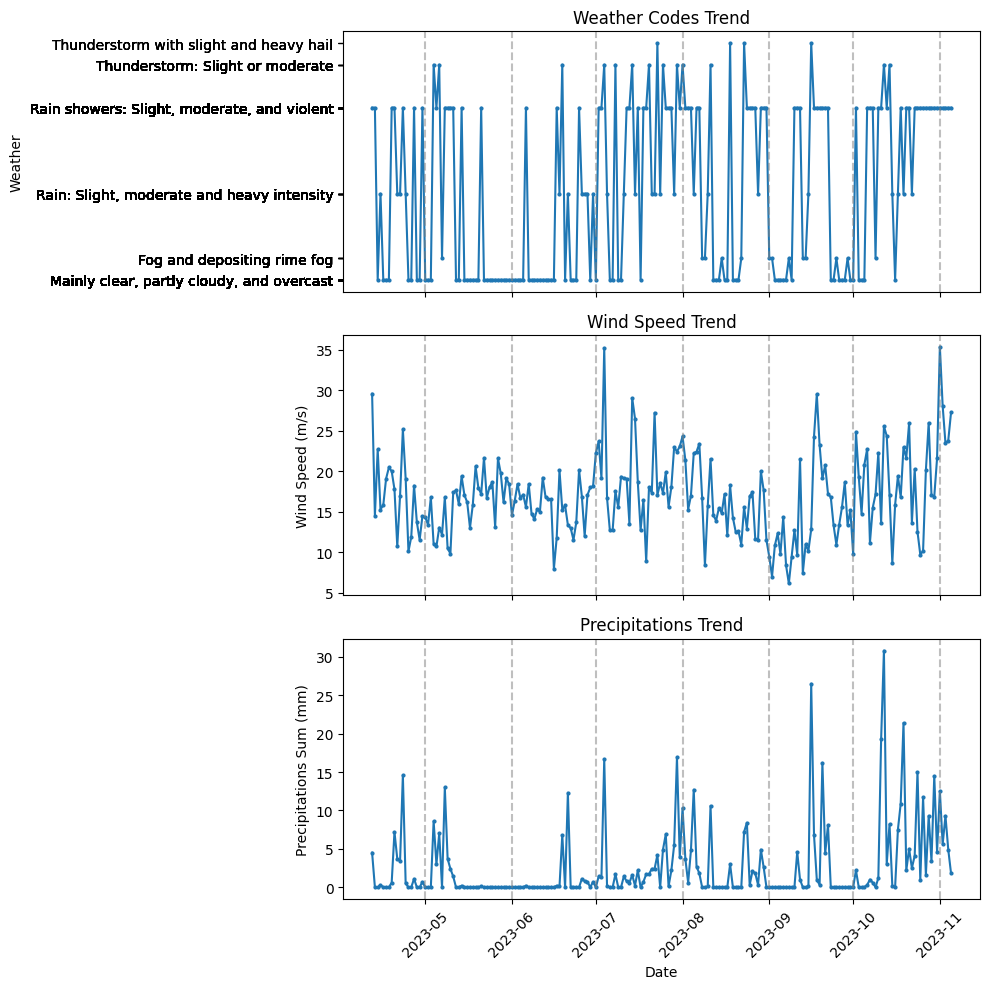

In [182]:
# Create a figure with three vertically aligned subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# First subplot: Weather Code
ax1.plot(df_hist_data['date'], df_hist_data['weather_code'], marker='o', linestyle='-', markersize=2)
ax1.set_ylabel('Weather')
ax1.set_title('Weather Codes Trend')

# Customize y-axis labels with weather code labels instead of numbers
ax1.set_yticks(df_hist_data['weather_code'])
ax1.set_yticklabels(df_hist_data['weather_code_label'])

# Second subplot: Wind Speed
ax2.plot(df_hist_data['date'], df_hist_data['wind_speed_max'], marker='o', linestyle='-', markersize=2)
ax2.set_ylabel('Wind Speed (m/s)')
ax2.set_title('Wind Speed Trend')

# Third subplot: Precipitations
ax3.plot(df_hist_data['date'], df_hist_data['precipitation_sum'], marker='o', linestyle='-', markersize=2)
ax3.set_xlabel('Date')
ax3.set_ylabel('Precipitations Sum (mm)')
ax3.set_title('Precipitations Trend')

# Repeat x-label in all subplots
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)
ax3.tick_params(axis='x', rotation=45)

# Display vertical lines aligned with x-ticks dates in all subplots
for tick in ax1.get_xticks():
    ax1.axvline(tick, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(tick, color='gray', linestyle='--', alpha=0.5)
    ax3.axvline(tick, color='gray', linestyle='--', alpha=0.5)

# Display the plot
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

In [183]:
df_hist_data.head()

,date,weather_code_wmo,precipitation_sum,wind_speed_max,month,weather_code_label,weather_code
142,2023-04-12,80,4.5,29.574827,4,"Rain showers: Slight, moderate, and violent",10
143,2023-04-13,80,0.0,14.512064,4,"Rain showers: Slight, moderate, and violent",10
144,2023-04-14,3,0.0,22.705700,4,"Mainly clear, partly cloudy, and overcast",2
145,2023-04-15,61,0.3,15.273505,4,"Rain: Slight, moderate and heavy intensity",6
146,2023-04-16,3,0.0,15.840000,4,"Mainly clear, partly cloudy, and overcast",2


# 5) Hopsworks Feature Store

In [187]:
# Connect to HopsWorks
project = hopsworks.login()

# retrieve feature store
fs = project.get_feature_store() 

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/178324
Connected. Call `.close()` to terminate connection gracefully.


In [188]:
# Create new Feature Store
weather_fg = fs.get_or_create_feature_group(
    name='weather',
    description='Daily Weather Information',
    version=1,
    primary_key=["month"],
    event_time=["date"]
)

In [189]:
# Insert Dataframe into Feature Store
weather_fg.insert(df_hist_data, write_options={"wait_for_job": False})

Uploading Dataframe: 0.00% |          | Rows 0/208 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: weather_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/178324/jobs/named/weather_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x14445db50>, None)